# Setup
In this first task, we will setup the Workbench environment, create a RAG solution from Alphabets 2022 financial annual report and perform some queries to the report. To store the embeddings we use Chroma, an open-source embeddings database that makes it straightforward to store embeddings.

https://abc.xyz/assets/d4/4f/a48b94d548d0b2fdc029a95e8c63/2022-alphabet-annual-report.pdf

https://www.trychroma.com/

In [1]:
# In the first cell run the following command to install the Google Cloud Vertex AI SDKs and required dependencies packages. Either click the play play button at the top or enter SHIFT+ENTER on your keyboard to execute the cell.
!pip3 install --upgrade --user google-cloud-aiplatform umap-learn tqdm pypdf
!pip3 uninstall -y numpy
!pip3 install "numpy<2"
!pip install opentelemetry-api==1.24.0 opentelemetry-sdk==1.24.0 opentelemetry-exporter-otlp-proto-grpc==1.24.0 opentelemetry-exporter-otlp-proto-common==1.24.0 opentelemetry-proto==1.24.0
!pip3 install chromadb==0.5.3  google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [umap-learn]
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 100.0 MB/s  0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/9 [protobuf]  WARNING: Failed to remove contents in a temporary directory '/opt/conda/lib/python3.10/site-packages/google/~rotobuf'.
  You can safely remove it manually.
  Attempting uninstall: opentelemetry-semantic-conventions
    Found existing installation: opentelemetry-semantic-conventions 0.58b0
    Uninstalling opentelemetry-semantic-conventions-0.58b0:━━━ 1/9 [opentelemetry-semantic-conventions]
      Successfully uninstalled opentelemetry-semantic-conventions-0.58b0 [opentelemetry-semantic-conventions]
  Attempting uninstall: im

In [ ]:
# Restart kernel after installs so that your environment can access the new packages.
import IPython
from IPython.display import Markdown, display
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

# Task 2. Setting up a RAG solution

In [2]:
# Initialize the environment variables for the current project.
PROJECT = !gcloud config get-value project
PROJECT_ID = PROJECT[0]
LOCATION = "us-central1"

In [3]:
# Import python display utilities and Google Cloud's Embeddings and Gemini models.
from vertexai.preview.generative_models import GenerativeModel
from vertexai.language_models import TextEmbeddingModel
text_embedding_model = TextEmbeddingModel.from_pretrained("text-embedding-004")
model = GenerativeModel('gemini-2.5-flash')

/opt/conda/lib/python3.10/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.29.5 is exactly one major version older than the runtime version 6.31.1 at google/protobuf/empty.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/jupyter/.local/lib/python3.10/site-packages/vertexai/_model_garden/_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()
/home/jupyter/.local/lib/python3.10/site-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show

In [6]:
# Download Alphabet's financial annual report for 2022 so that we can query it.
import urllib.request

# ORIGINAL URL
# https://abc.xyz/assets/d4/4f/a48b94d548d0b2fdc029a95e8c63/2022-alphabet-annual-report.pdf
# # download alphabet's annual pdf report
# url = "https://abc.xyz/assets/d4/4f/a48b94d548d0b2fdc029a95e8c63"
# file = "2022-alphabet-annual-report.pdf"


# TROUBLESHOOT AND FIX URL
# https://abc.xyz/investor/sec-filings/annual-filings/2022/
# https://d18rn0p25nwr6d.cloudfront.net/CIK-0001652044/287eecc5-a885-4a20-8d15-a6847ee5086f.pdf
# download alphabet's annual pdf report
url = "https://d18rn0p25nwr6d.cloudfront.net/CIK-0001652044"
file = "287eecc5-a885-4a20-8d15-a6847ee5086f.pdf"

urllib.request.urlretrieve(f"{url}/{file}", filename=f"{file}")

('287eecc5-a885-4a20-8d15-a6847ee5086f.pdf',
 <http.client.HTTPMessage at 0x7f8bde49ee00>)

In [7]:
# Convert the PDF into text.
!pip install PyPDF2
import PyPDF2

# Open the PDF file in binary mode
# with open('2022-alphabet-annual-report.pdf', 'rb') as file:
# FIX
with open(file, 'rb') as file:
    # Create a PdfFileReader object
    pdf_reader = PyPDF2.PdfReader(file)
    pdf_texts = [p.extract_text().strip() for p in pdf_reader.pages]

    # Filter the empty strings
    pdf_texts = [text for text in pdf_texts if text]

    print(pdf_texts[0])

UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
___________________________________________
FORM 10-K
___________________________________________
(Mark One)
☒ ANNUAL  REPORT PURSUANT T O SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the fiscal year ended December 31, 2021
OR
☐ TRANSITION REPORT PURSUANT T O SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the transition period from              to             .
Commission file number: 001-37580
___________________________________________
Alphabet Inc.
(Exact name of registrant as specified in its charter)
___________________________________________
Delaware 61-1767919
(State or other jurisdiction of incorporation or organization) (I.R.S. Employer Identification No.)
1600 Amphitheatre Parkway
Mountain V iew, CA 94043
(Address of principal executive offices, including zip code)
(650) 253-0000
(Registrant's telephone number, including area code)
Securities registered pursuant to Secti

## Chunk Option 1 - RecursiveCharacterTextSplitter 1k chars per chunk
* Prioritizing breaking at semantically important points like paragraphs (\n\n) and lines (\n)
* This prevents a sentence from being awkwardly cut in half just because it hit the 1000-character limit

You're hitting a breaking change in LangChain’s import paths. Since mid‑2024 and reinforced in later docs (updated through 2025), text splitters were moved out of the langchain package into a separate distribution: langchain-text-splitters. So importing from langchain.text_splitter now fails with ModuleNotFoundError. The current docs show you should import from langchain_text_splitters after installing that package.

Old https://python.langchain.com/docs/concepts/text_splitters/

New https://docs.langchain.com/oss/python/integrations/splitters/index

In [9]:
# Split the PDF into chunks so that we can create embedding out of them. The embedding's APIs and the LLM have token limits, that's why we need to split the text into smaller units as opposed to sending the whole text.
# !pip install langchain sentence-transformers
# # ModuleNotFoundError: No module named 'langchain.text_splitter'
# from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter


# Use -q to keep the output tidy; upgrade to latest compatible versions
%pip install -qU langchain-text-splitters sentence-transformers

from langchain_text_splitters import (
    RecursiveCharacterTextSplitter,
    SentenceTransformersTokenTextSplitter,  # requires sentence-transformers installed
)


character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

print(character_split_texts[10])
print(f"\nTotal chunks: {len(character_split_texts)}")

Note: you may need to restart the kernel to use updated packages.
•the expected variability of gains and losses related to hedging activities under our foreign exchange risk management program;
•the amount and timing of revenue recognition from customer contracts with commitments for performance obligations, including our estimate
of the remaining amount of commitments and when we expect to recognize revenue;
•fluctuations in our capital expenditures;
•our plans to continue to invest in new businesses, products, services and technologies, systems, land and buildings for data centers and
offices, and infrastructure, as well as to continue to invest in acquisitions and strategic investments;
•our pace of hiring and our plans to provide competitive compensation programs;
•our expectation that our cost of revenues, research and development (R&D) expenses, sales and marketing expenses, and general and
administrative expenses may increase in amount and/or may increase as a percentage of reve

In [10]:
# 12-TH CHUNK
print(character_split_texts[11])

•estimates of our future compensation expenses;
•our expectation that our other income (expense), net (OI&E), will fluctuate in the future, as it is largely driven by market dynamics;
•fluctuations in our effective tax rate;
•seasonal fluctuations in internet usage and advertiser expenditures, underlying business trends such as traditional retail seasonality, which
are likely to cause fluctuations in our quarterly results;
•the sufficiency of our sources of funding;
•our potential exposure in connection with new and pending investigations, proceedings, and other contingencies;
3


## Chunk Option 2 - SentenceTransformersTokenTextSplitter 256 tokens per chunk
* try to be compatible with models with strict token limit (e.g., 512, 1024, or 2048 tokens)

In [11]:
# Create more chunks if the size of the existing chunk is too big. In this case, we define too big as 256 tokens.
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print(token_split_texts[10])
print(f"\nTotal chunks: {len(token_split_texts)}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

table of contents alphabet inc. note about forward - looking statements this annual report on form 10 - k contains forward - looking statements within the meaning of the private securities litigation reform act of 1995. these include, among other things, statements regarding : • the ongoing effect of the novel coronavirus pandemic ( " covid - 19 " ), including its macroeconomic effects on our business, operations, and financial results ; • the growth of our business and revenues and our expectations about the factors that influence our success and trends in our business ; • fluctuations in our revenue growth rate and operating margin and various factors contributing to such fluctuations ; • our expectation that the continuing shift from an offline to online world will continue to benefit our business ; • our expectation that the portion of our revenues that we derive from non - advertising revenues will continue to increase and may affect our margins ;

Total chunks: 535


In [12]:
# 12-TH CHUNK
print(token_split_texts[11])

• our expectation that our traffic acquisition costs ( tac ) and the associated tac rate will fluctuate, which could affect our overall margins ; • our expectation that our monetization trends will fluctuate, which could affect our revenues and margins ; • fluctuations in our revenue growth, as well as the change in paid clicks and cost - per - click and the change in impressions and cost - per - impression, and various factors contributing to such fluctuations ; • our expectation that we will continue to periodically review, refine, and update our methodologies for monitoring, gathering, and counting the number of paid clicks and impressions ; • our expectation that our results will be affected by our performance in international markets as users in developing economies increasingly come online ; • our expectation that our foreign exchange risk management program will not fully offset our net exposure to fluctuations in foreign currency exchange rates ;


In [13]:
# Install and initialize the embeddings database with an embeddings function.

import chromadb
import os
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
# import chromadb.utils.embedding_functions as embedding_functions

# import getpass
# import os

# getpass will prompt for an API Key
# The API Key is needed for Chroma DB
# API_KEY = getpass.getpass("Provide your Google API Key")

# embedding_function = embedding_functions.GooglePalmEmbeddingFunction(api_key=creds.token)

embedding_function = SentenceTransformerEmbeddingFunction()
print(embedding_function([token_split_texts[10]]))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[[-0.0365925133228302, -0.010703692212700844, -0.0021942227613180876, -0.049676235765218735, 0.07546355575323105, 0.0888473391532898, 0.026042718440294266, 0.05991791933774948, 0.054373979568481445, 0.02498079463839531, 0.009887986816465855, 0.14011138677597046, -0.017944460734725, -0.05805475264787674, 0.01252768374979496, -0.03697869926691055, -0.013064882718026638, -0.007141645532101393, -0.014935622923076153, 0.019037894904613495, 0.00034864037297666073, 0.10924924165010452, 0.0016119707142934203, 0.04441283643245697, -0.029929647222161293, 0.0005316922906786203, -0.09327124059200287, -0.0345306321978569, -0.08202841132879257, -0.011286755092442036, -0.02656101994216442, 0.03735397011041641, 0.05736353620886803, 0.010217706672847271, 0.05504707619547844, -0.06269529461860657, 0.0015724350232630968, -0.02006382681429386, 0.03998721018433571, 0.005623972043395042, 0.04061003401875496, -0.09758540987968445, -0.02094629779458046, 0.010858150199055672, 0.0676194280385971, -0.01673540472

In [16]:
# 384-dim embedding vector
len(embedding_function([token_split_texts[10]])[0])

384

In [17]:
# Create embedings and store them in the chroma database.
chroma_client = chromadb.Client()
print("collection")
chroma_collection = chroma_client.create_collection("alphabet_annual_report_2022", embedding_function=embedding_function)
print("created")
ids = [str(i) for i in range(len(token_split_texts))]
print("adding")
chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

collection
created
adding


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionAddEvent: capture() takes 1 positional argument but 3 were given


535

In [18]:
chroma_collection

In [19]:
chroma_collection.__dict__

{'_client': <chromadb.api.segment.SegmentAPI at 0x7f8aa5580340>,
 '_model': {'id': UUID('45ff507d-42b1-4708-91a0-5107f2932c18'),
  'name': 'alphabet_annual_report_2022',
  'metadata': None,
  'dimension': None,
  'tenant': 'default_tenant',
  'database': 'default_database',
  'version': 0},
 '_embedding_function': <chromadb.utils.embedding_functions.SentenceTransformerEmbeddingFunction at 0x7f8aa6ede260>,
 '_data_loader': None}

In [23]:
chroma_collection._client.__dict__

{'_dependencies': {<chromadb.db.impl.sqlite.SqliteDB at 0x7f8aa5581f90>,
  <chromadb.telemetry.product.posthog.Posthog at 0x7f8aa7070460>},
 '_system': <chromadb.config.System at 0x7f8aa55df910>,
 '_running': True,
 '_settings': Settings(environment='', chroma_api_impl='chromadb.api.segment.SegmentAPI', chroma_server_nofile=None, chroma_server_thread_pool_size=40, tenant_id='default', topic_namespace='default', chroma_server_host=None, chroma_server_headers=None, chroma_server_http_port=None, chroma_server_ssl_enabled=False, chroma_server_ssl_verify=None, chroma_server_api_default_path='/api/v1', chroma_server_cors_allow_origins=[], is_persistent=False, persist_directory='./chroma', chroma_memory_limit_bytes=0, chroma_segment_cache_policy=None, allow_reset=False, chroma_auth_token_transport_header=None, chroma_client_auth_provider=None, chroma_client_auth_credentials=None, chroma_server_auth_ignore_paths={'/api/v1': ['GET'], '/api/v1/heartbeat': ['GET'], '/api/v1/version': ['GET']}, ch

In [27]:
chroma_collection._client._sysdb.__dict__

{'_settings': Settings(environment='', chroma_api_impl='chromadb.api.segment.SegmentAPI', chroma_server_nofile=None, chroma_server_thread_pool_size=40, tenant_id='default', topic_namespace='default', chroma_server_host=None, chroma_server_headers=None, chroma_server_http_port=None, chroma_server_ssl_enabled=False, chroma_server_ssl_verify=None, chroma_server_api_default_path='/api/v1', chroma_server_cors_allow_origins=[], is_persistent=False, persist_directory='./chroma', chroma_memory_limit_bytes=0, chroma_segment_cache_policy=None, allow_reset=False, chroma_auth_token_transport_header=None, chroma_client_auth_provider=None, chroma_client_auth_credentials=None, chroma_server_auth_ignore_paths={'/api/v1': ['GET'], '/api/v1/heartbeat': ['GET'], '/api/v1/version': ['GET']}, chroma_overwrite_singleton_tenant_database_access_from_auth=False, chroma_server_authn_provider=None, chroma_server_authn_credentials=None, chroma_server_authn_credentials_file=None, chroma_server_authz_provider=None,

In [26]:
chroma_collection._model["id"]

UUID('45ff507d-42b1-4708-91a0-5107f2932c18')

In [20]:
chroma_collection._embedding_function.__dict__

{'_model': SentenceTransformer(
   (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
   (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
   (2): Normalize()
 ),
 '_normalize_embeddings': False}

## qn1 - total rev

In [30]:
# Ask a questions to perform an embeddings search on the chroma db database.
query = "What was the total revenue?"

results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results['documents'][0]

i = 1
for document in retrieved_documents:
    print(f"Document {i}")
    print(document)
    print('\n')
    i+=1

Document 1
accounting estimate was effective beginning in fiscal year 2021. based on the carrying value of servers and certain network equipment as of december 31, 2020 and those acquired during the year ended december 31, 2021, the effect of this change in estimate was a reduction in depreciation expense of $ 2. 6 billion and an increase in net income of $ 2. 0 billion, or $ 3. 02 per basic share and $ 2. 98 per diluted share, for the year ended december 31, 2021. revenue recognition revenues are recognized when control of the promised goods or services is transferred to our customers, and the collectibility of an amount that we expect in exchange for those goods or services is probable. sales and other similar taxes are excluded from revenues. advertising revenues we generate advertising revenues primarily by delivering advertising on : • google search and other properties, including revenues from traffic generated by search distribution partners who use google. com as their


Docume

In [31]:
# Use a RAG to answer the question given the information that was looked up from the database.
def rag(query, retrieved_documents, model):
    information = "\n\n".join(retrieved_documents)

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'Your users are asking questions about information contained in an annual report.\n'
    f'You will be shown the user\'s question, and the relevant information from the annual report.\n'
    f'Answer the user\'s question using only this information.\n\n'
    f'Question: {query}. \n Information: {information}')

    responses = model.generate_content(prompt, stream=False)
    return responses.text

response = rag(query=query, retrieved_documents=retrieved_documents, model=model)
print(response)

Based on the information provided:

For the year ended December 31, 2021:
Sales and marketing expenses were $22,912 million, which represented 8.9% of revenues.
Therefore, total revenue = $22,912 million / 0.089 = **$257,438 million** (or $257.4 billion).

For the year ended December 31, 2020:
Sales and marketing expenses were $17,946 million, which represented 9.8% of revenues.
Therefore, total revenue = $17,946 million / 0.098 = **$183,122 million** (or $183.1 billion).


# Task 3. Explore embeddings distribution with user queries
In this task, we use the python library umap to reduce the dimensions of our embeddings to two dimensions, so that we can see how close they are represented in a graph. Then we try different queries to see how different queries relate to the existing embedding space. This can give us an intuition about whether the answer might be found in the embeddings space.



In [32]:
# Transform embeddings into a 2-dimensional space
# using UMAP
import umap.umap_ as umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionGetEvent: capture() takes 1 positional argument but 3 were given
/home/jupyter/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
100%|██████████| 535/535 [00:04<00:00, 129.64it/s]


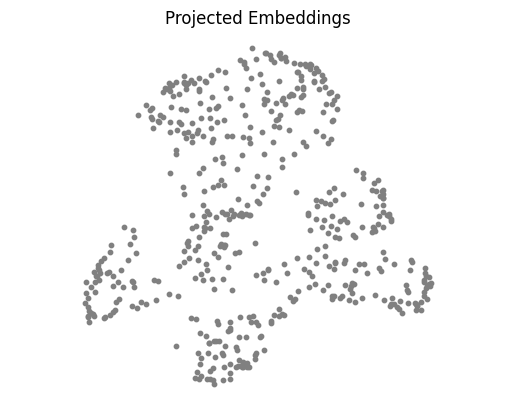

In [33]:
# Plot the 2-dimensional embeddings.
import matplotlib.pyplot as plt

def plot(title='Projected Embeddings', projected_dataset_embeddings=[], projected_query_embedding=[], projected_retrieved_embeddings=[]):
    # Plot the projected query and retrieved documents in the embedding space
    plt.figure()
    plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
    if len(projected_query_embedding) > 0:
        plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
    if len(projected_retrieved_embeddings) > 0:
        plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{title}')
    plt.axis('off')

plot(projected_dataset_embeddings=projected_dataset_embeddings)

# qn1 - total rev

In [45]:
# Ask the same question to the database again, but this time retrieve the embeddings in addition to the documents.
query = "What was the total revenue?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]


i = 1
for document in results['documents'][0]:
    print(f"Document {i}")
    print(document)
    print('\n')
    i+=1

Document 1
accounting estimate was effective beginning in fiscal year 2021. based on the carrying value of servers and certain network equipment as of december 31, 2020 and those acquired during the year ended december 31, 2021, the effect of this change in estimate was a reduction in depreciation expense of $ 2. 6 billion and an increase in net income of $ 2. 0 billion, or $ 3. 02 per basic share and $ 2. 98 per diluted share, for the year ended december 31, 2021. revenue recognition revenues are recognized when control of the promised goods or services is transferred to our customers, and the collectibility of an amount that we expect in exchange for those goods or services is probable. sales and other similar taxes are excluded from revenues. advertising revenues we generate advertising revenues primarily by delivering advertising on : • google search and other properties, including revenues from traffic generated by search distribution partners who use google. com as their


Docume

In [46]:
# Embed the question and answer and transform it into two dimentions.
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:00<00:00, 202.26it/s]


In [41]:
len(retrieved_embeddings)

5

In [42]:
len(projected_retrieved_embeddings)

5

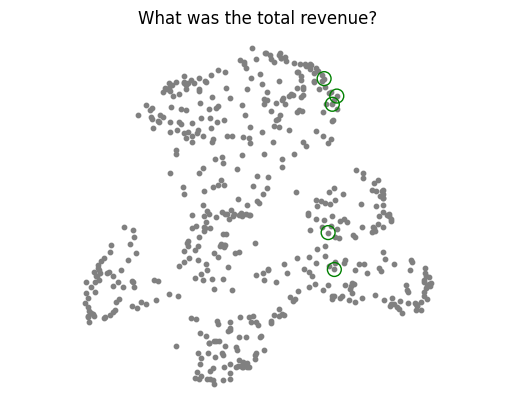

In [48]:
# Plot the projected query and retrieved documents in the embedding space.
plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

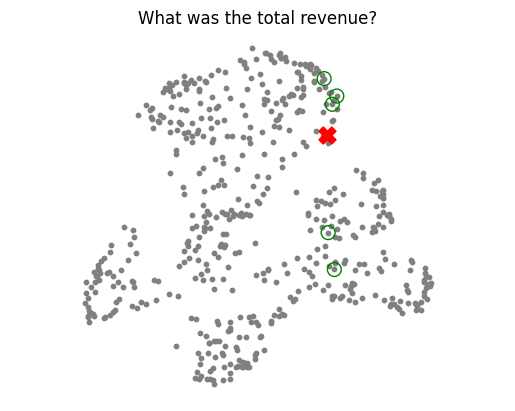

In [49]:
# ADD 'projected_query_embedding'
plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=projected_query_embedding, projected_retrieved_embeddings=projected_retrieved_embeddings)

In [47]:
projected_retrieved_embeddings

array([[6.38841724, 7.19303226],
       [6.71093702, 6.74965191],
       [6.64849043, 2.34025002],
       [6.59716702, 6.54089546],
       [6.49032354, 3.2780087 ]])

Student comments
- it seems that the 5 retrieved embeddings most similar to the original query are far apart
- 3 are in 1 cluster above, while 2 are in another cluster below
  - using the embeddings' y-coordinates as a guide
  - embeddings 3 and 5 with y-coordinates of 2 or 3 are in the cluster below - looking at income, long-lived assets and taxes
  - embeddings 1,2,4 with y-coordinates of 6 or 7 are in the cluster above - looking at expenses and cash flow
- The query embedding (about revenue) is closer to the cluster above (with 3 embeddings about expenses)
  - which is surprising to me because revenue is more semantically similar to the concept of income


## qn2 - AI strat

In [50]:
# Let's try again with a different question to see another example.
query = "What is the strategy around artificial intelligence (AI) ?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

i = 1
for document in results['documents'][0]:
    print(f"Document {i}")
    print(document)
    print('\n')
    i+=1

Document 1
across the company, investments in ai and machine learning are increasingly driving many of our latest innovations and have enabled us to build products that are smarter and more helpful. for example, in may of 2021, we introduced multitask unified model — or mum — which has the potential to transform how google helps with complex tasks. mum is trained across 75 different languages, which means that it can learn from sources written in one language and help bring that information to people in another. it is also multimodal, so it understands information across text and images and, in the future, can expand to more modalities like video and audio. we are currently experimenting with mum ’ s capabilities to make searching more natural and intuitive and even enable entirely new ways to search. deepmind also made a significant ai - powered breakthrough, solving a 50 - year - old protein folding challenge, which will help the world better


Document 2
toward our goal of making tr

In [51]:
# Create embeddings and projections.
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:00<00:00, 24.07it/s]


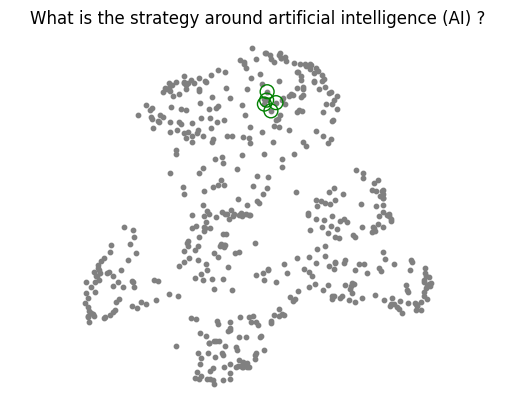

In [40]:
# Plot the projected query and retrieved documents in the embedding space. Notice how close results are, since the answer seems to be contained in the database.
plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

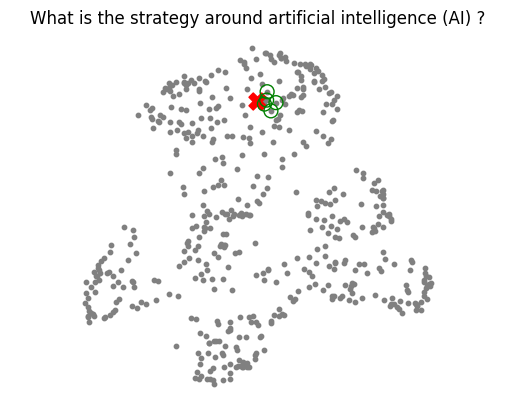

In [52]:
# ADDED to see the 'query coordinates'
plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=projected_query_embedding, projected_retrieved_embeddings=projected_retrieved_embeddings)

Student comments
- it seems that ALL 5 RETRIEVED EMBEDDINGS were similar to the input query about AI strategy - GOOD

## qn3 - LT Fin Goals

Document 1
liabilities, or amortization expenses, or impairment of goodwill and / or purchased long - lived assets, and restructuring charges, any of which could harm our financial condition or operating results. also, the anticipated benefits or value of our acquisitions and other strategic transactions may not materialize. in connection with our divestitures, we have agreed, and may in the future agree, to provide indemnification for certain potential liabilities, which may harm our financial condition or operating results. if we were to lose the services of key personnel, we may not be able to execute our business strategy. our future success depends in large part upon the continued service of key members of our senior management team. for instance, sundar pichai is critical to the overall management of alphabet and its subsidiaries and plays an important role in the development of our technology,


Document 2
• the expected variability of gains and losses related to hedging activit

100%|██████████| 5/5 [00:00<00:00, 285.01it/s]


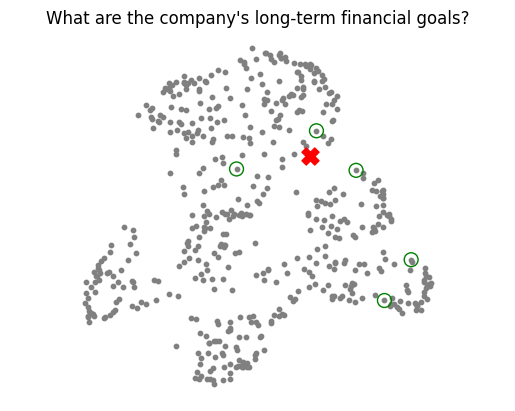

In [53]:
# Let's do all these again with another question that might be contained in the dataset to see that results are still close to one another.
query = "What are the company's long-term financial goals?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

i = 1
for document in results['documents'][0]:
    print(f"Document {i}")
    print(document)
    print('\n')
    i+=1

query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=projected_query_embedding, projected_retrieved_embeddings=projected_retrieved_embeddings)

In [54]:
projected_query_embedding

array([[6.02439833, 5.21311522]])

In [55]:
projected_retrieved_embeddings

array([[4.16153049, 4.89622879],
       [7.20123243, 4.86128855],
       [6.1934185 , 5.86674261],
       [8.60106659, 2.58885288],
       [7.92143583, 1.5520066 ]])

Student comments
- it seems that 3rd retrieved embedding is closest to the query
- 3rd retrieved embedding looks at estimates of future accounting items
- query looks at long term financial goals
- SO the closest retrieved embedding is the BEST MATCH

## qn4 - Out of scope qn

Document 1
other bets 659 657 753 hedging gains ( losses ) 455 176 149 total revenues $ 161, 857 $ 182, 527 $ 257, 637 no individual customer or groups of affiliated customers represented more than 10 % of our revenues in 2019, 2020, or 2021. 60


Document 2
table of contents alphabet inc. the following tables summarize debt securities, for which we did not elect the fair value option, by significant investment categories as of december 31, 2020 and 2021 ( in millions ) : as of december 31, 2020 adjusted costgross unrealized gainsgross unrealized lossesfair valuecash and cash equivalentsmarketable securities level 2 : time deposits $ 3, 564 $ 0 $ 0 $ 3, 564 $ 3, 564 $ 0 government bonds 55, 156 793 ( 9 ) 55, 940 2, 527 53, 413 corporate debt securities 31, 521 704 ( 2 ) 32, 223 8 32, 215 mortgage - backed and asset - backed securities 16, 767 364 ( 7 ) 17, 124 0 17, 124 total $ 107, 008 $ 1, 861 $ ( 18 ) $ 108, 851 $ 6, 099 $ 102, 752 as of december 31, 2021 adjusted costgross unrealiz

100%|██████████| 5/5 [00:00<00:00, 142.14it/s]


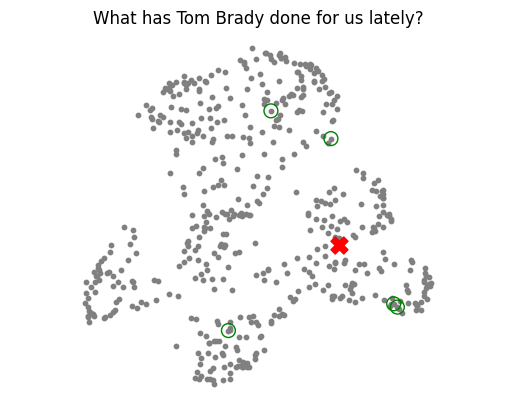

In [56]:
# Now, let's use an unrelated query and we'll observe how the results are more scattered around. Notice that the algorithm always returns close neighbors even if they are far appart. This is an indication that is returning results that are not necesseraly related to the query.
query = "What has Tom Brady done for us lately?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

i = 1
for document in results['documents'][0]:
    print(f"Document {i}")
    print(document)
    print('\n')
    i+=1

query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=projected_query_embedding, projected_retrieved_embeddings=projected_retrieved_embeddings)

Student comments
- it seems that the 5 retrieved embeddings were far from the 'original query out of scope from the dataset' in the 2D space
- it is interesting that there are other embeddings close to the 'original out of scope query' in the 2D space, yet they might be further apart in the 384-dimensional space generated by the embedding function


# Task 4. Query augmentation

One way of improving the results from queries is by getting more results of similar queries. This can be done either by creating similar queries or by sending an answer of what you might expect, so that you attach more context. In this task, you learn to expand your queries leveraging LLMs to do the heavy lifting.



## From query > Give sample ans

In [57]:
# Augment the query with a probable answer to give more context to the vector search.
def augment_query_generated(query, model):
    information = "\n\n".join(retrieved_documents)

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'Provide an example answer to the given question, that might be found in a document like an annual report.\n'
    f'Question: {query}.')

    responses = model.generate_content(prompt, stream=False)
    return responses.text

original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query, model)

joint_query = f"{original_query} {hypothetical_answer}"
print(joint_query)


Was there significant turnover in the executive team? Yes, the past fiscal year saw several significant, yet strategically managed, changes within our executive leadership team. These transitions were primarily driven by planned succession, strategic realignment, and individuals pursuing new opportunities.

Specifically:

*   **Mr. John Smith, Chief Financial Officer**, retired in Q2 after 20 years of dedicated service to the company. His departure was part of a long-term succession plan. We were pleased to promote **Ms. Emily White** from her role as VP of Corporate Finance to CFO, effective July 1st. Ms. White brings extensive institutional knowledge and a proven track record.
*   **Ms. Jane Doe, Chief Operating Officer**, resigned in Q3 to pursue an external opportunity. Her contributions were invaluable during her tenure. We conducted a thorough external search and appointed **Dr. Michael Green** as the new COO, effective October 1st. Dr. Green brings over 25 years of operational e

In [66]:
# Perform the query with the new augmented query.
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

i=1
for doc in retrieved_documents:
    print(f"Document {i}")
    print(doc)
    print('')
    i+=1

Document 1
liabilities, or amortization expenses, or impairment of goodwill and / or purchased long - lived assets, and restructuring charges, any of which could harm our financial condition or operating results. also, the anticipated benefits or value of our acquisitions and other strategic transactions may not materialize. in connection with our divestitures, we have agreed, and may in the future agree, to provide indemnification for certain potential liabilities, which may harm our financial condition or operating results. if we were to lose the services of key personnel, we may not be able to execute our business strategy. our future success depends in large part upon the continued service of key members of our senior management team. for instance, sundar pichai is critical to the overall management of alphabet and its subsidiaries and plays an important role in the development of our technology,

Document 2
item 10. directors, executive officers and corporate governance 88 item 11

In [67]:
# Search for embeddings for the augmented query.
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

i=1
for doc in retrieved_documents:
    print(f"Document {i}")
    print(doc)
    print('')
    i+=1

Document 1
liabilities, or amortization expenses, or impairment of goodwill and / or purchased long - lived assets, and restructuring charges, any of which could harm our financial condition or operating results. also, the anticipated benefits or value of our acquisitions and other strategic transactions may not materialize. in connection with our divestitures, we have agreed, and may in the future agree, to provide indemnification for certain potential liabilities, which may harm our financial condition or operating results. if we were to lose the services of key personnel, we may not be able to execute our business strategy. our future success depends in large part upon the continued service of key members of our senior management team. for instance, sundar pichai is critical to the overall management of alphabet and its subsidiaries and plays an important role in the development of our technology,

Document 2
item 10. directors, executive officers and corporate governance 88 item 11

In [61]:
# Get the embeddings for the queries and results and then map them to a 2-dimensional space.
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:00<00:00, 189.11it/s]


(-0.12157976627349854,
 9.53650963306427,
 -1.0034998893737792,
 8.393845462799073)

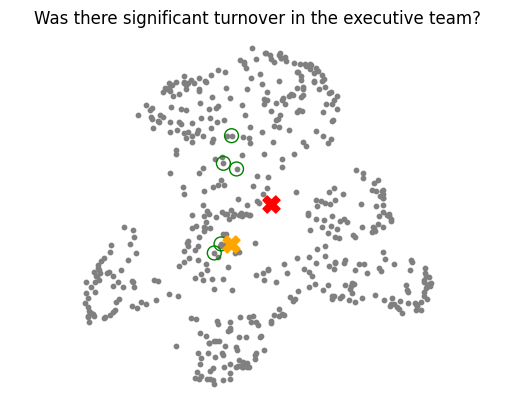

In [63]:
# Map the results to get a visual understanding of the outcome. Notice that the seleted answers are closer to the augmented query datapoint.
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
# red = original query
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
# orange = augmented query
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

In [68]:
# so retrieved items 2 and 3 are closest to the augmented query
# about the executive team and their turnover
projected_retrieved_embeddings

array([[4.16153049, 4.89622879],
       [3.5962007 , 2.76051331],
       [3.76753855, 2.99082994],
       [4.03425217, 5.74203825],
       [3.82751346, 5.04065132]])

In [70]:
retrieved_documents

['liabilities, or amortization expenses, or impairment of goodwill and / or purchased long - lived assets, and restructuring charges, any of which could harm our financial condition or operating results. also, the anticipated benefits or value of our acquisitions and other strategic transactions may not materialize. in connection with our divestitures, we have agreed, and may in the future agree, to provide indemnification for certain potential liabilities, which may harm our financial condition or operating results. if we were to lose the services of key personnel, we may not be able to execute our business strategy. our future success depends in large part upon the continued service of key members of our senior management team. for instance, sundar pichai is critical to the overall management of alphabet and its subsidiaries and plays an important role in the development of our technology,',
 'item 10. directors, executive officers and corporate governance 88 item 11. executive compe

In [ ]:
## From retrieved docs above > query new qn about new topic

# NOW
# ASK A NEW QN
# USING THE 5 RETRIEVED DOCS ABOUT EXECUTIVE TEAM TURNOVER

## From 1 qn > give 5 more qns

In [71]:
# Augment the query with a additional queries.
def augment_multiple_query(query, model):
    information = "\n\n".join(retrieved_documents)

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'Your users are asking questions about an annual report.\n'
    f'Suggest up to five additional related questions to help them find the information they need, for the provided question.\n'
    f'Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic.\n'
    f'Make sure they are complete questions, and that they are related to the original question.\n'
    f'Output one question per line. Do not number the questions.\n'
    f'Question: {query}.')

    responses = model.generate_content(prompt, stream=False)
    return responses.text

original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query, model)

joint_query = f"{original_query} \n{augmented_queries}"
print(joint_query)

What were the most important factors that contributed to increases in revenue? 
Which product lines grew most significantly?
Were increased sales volumes a primary driver?
Did higher average selling prices contribute?
What role did new market entry play?
How did customer acquisition impact revenue?


In [72]:
# Retrieve answers for all of these queries.
queries = [original_query] + augmented_queries.split('\n')
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(doc)
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
the following table presents sales and marketing expenses ( in millions, except percentages ) : year ended december 31, 2020 2021 sales and marketing expenses $ 17, 946 $ 22, 912 sales and marketing expenses as a percentage of revenues 9. 8 % 8. 9 % sales and marketing expenses increased $ 5. 0 billion from 2020 to 2021, primarily driven by an increase in advertising and promotional activities of $ 2. 5 billion and an increase in compensation expenses of $ 2. 2 billion. the increase in advertising and promotional activities was driven by both increased spending in the current period and a reduction in spending in 2020 due to covid - 19. the increase in compensation expenses was largely due to a 14 % increase in headcount. general and administrative the following table presents general and administrative expenses ( in millions, except percentages ) : year ended december 31, 2020 2021 general 

In [76]:
# 1 original query
# AND 5 new qns
len(retrieved_documents)

6

In [78]:
# 5 retrieved docs per qn
len(retrieved_documents[0])

5

In [77]:
retrieved_documents

[['the following table presents sales and marketing expenses ( in millions, except percentages ) : year ended december 31, 2020 2021 sales and marketing expenses $ 17, 946 $ 22, 912 sales and marketing expenses as a percentage of revenues 9. 8 % 8. 9 % sales and marketing expenses increased $ 5. 0 billion from 2020 to 2021, primarily driven by an increase in advertising and promotional activities of $ 2. 5 billion and an increase in compensation expenses of $ 2. 2 billion. the increase in advertising and promotional activities was driven by both increased spending in the current period and a reduction in spending in 2020 due to covid - 19. the increase in compensation expenses was largely due to a 14 % increase in headcount. general and administrative the following table presents general and administrative expenses ( in millions, except percentages ) : year ended december 31, 2020 2021 general and administrative expenses $ 11, 052 $ 13, 510',
  'other income ( expense ), net $ 6, 858 $

In [81]:
# QUESTION: HOW DID WE GET 219 augmented query embedings????
# '219' comes from num of characters from the 5 additional queries/qns generated by LLM
# so we got 1 384-dim embedding for each character
len(augmented_query_embeddings), len(augmented_query_embeddings[0])

(219, 384)

In [107]:
original_query

'What were the most important factors that contributed to increases in revenue?'

In [108]:
len(original_query)

78

In [109]:
augmented_queries

'Which product lines grew most significantly?\nWere increased sales volumes a primary driver?\nDid higher average selling prices contribute?\nWhat role did new market entry play?\nHow did customer acquisition impact revenue?'

In [110]:
len(augmented_queries)

219

In [73]:
# Project the queries embeddings into a 2-dimensional space.
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

100%|██████████| 219/219 [00:00<00:00, 297.97it/s]


In [74]:
# Project the answer embeddings into a 2-dimensional space.
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

100%|██████████| 30/30 [00:00<00:00, 325.70it/s]


(-0.12157976627349854,
 9.53650963306427,
 -1.0040213584899902,
 8.404796314239501)

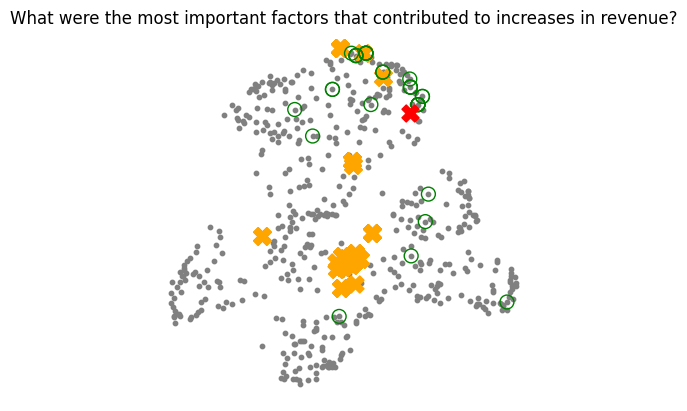

In [75]:
# Plot the queries and answers to visualize their representation in space.
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

# Task 5. Re-ranking results
With the query expansion technique that we just discussed, we increased the cardinality of responses. We have a new problem now. The high amount of responses might be larges than the LLM's input token limit and, it will be more expensive to process such a high amount of tokens, since we are billed per token. One solution to this problem is to rerank the results and only send the most relevant ones. Now, instead of using the same cosine-similarity method as before, you could use a cross-encoder, a method that usually yields better results.



In [82]:
# Import a cross encoder model.
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [83]:
cross_encoder

CrossEncoder(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 384, padding_idx=0)
        (position_embeddings): Embedding(512, 384)
        (token_type_embeddings): Embedding(2, 384)
        (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-5): 6 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=384, out_features=384,

In [84]:
# Create unique pairs of query to document.
pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

In [86]:
pairs[0]

['What were the most important factors that contributed to increases in revenue?',
 'regulatory, and other challenges, which may negatively affect our brands and demand for our products and services. because all of these new ventures are inherently risky, no assurance can be given that such strategies and offerings will be successful and will not harm our reputation, financial condition, and operating results. our revenue growth rate could decline over time, and we anticipate downward pressure on our operating margin in the future. our revenue growth rate could decline over time as a result of a number of factors, including increasing competition. changes in device mix, geographic mix, ongoing product and policy changes, product mix, and property mix and an increasing competition for advertising may also affect our advertising revenue growth rate. we may also experience a decline in our revenue growth rate as our revenues increase to higher levels, if there is a']

In [87]:
len(pairs)

17

In [88]:
# Compute an print the similarity between the pairs.
scores = cross_encoder.predict(pairs)

print("Scores:")
for score in scores:
    print(score)

Scores:
-0.9712277
-5.8740263
-0.3303551
-0.9054482
-11.029303
-6.2903166
-8.455056
-10.99262
-7.1802645
-8.673282
-6.0480146
-11.219526
-3.766006
-10.963417
-11.047906
-5.077244
-11.07251


In [89]:
# Reorder the pairs in terms of relevance.
print("New Ordering:")
ranked_docs=['']*len(scores)

# starting from 0-index
i = 0
for position in np.argsort(scores)[::-1]:
    ranked_docs[position] = pairs[i][1]
    i+=1
    print(position)

New Ordering:
2
3
0
12
15
1
10
5
8
6
9
13
7
4
14
16
11


In [90]:
# Print the 5 most relevant documents.
ranked_docs[:5]

['decrease in the rate of adoption of our products, services, and technologies, or due to deceleration or decline in demand for devices used to access our services, among other factors. in addition, we may also experience downward pressure on our operating margin resulting from a variety of factors, such as the continued expansion of our business into new fields, including products and services such as hardware, google cloud, and subscription products, as well as significant investments in other bets, all of which may have margins lower than those we generate from advertising. we may also experience downward pressure on our operating margins from increasing regulations, increasing competition, and increased costs for many aspects of our business. due to these factors and the evolving nature of our business, our historical revenue growth rate and historical operating margin may not be',
 '• operating cash flow was $ 91. 7 billion, primarily driven by revenues generated from our advertis

In [91]:
# Only send the most relevant answers to the LLM.
response = rag(query=original_query, retrieved_documents=ranked_docs[:5], model=model)
print(original_query)
print(response)

What were the most important factors that contributed to increases in revenue?
Revenues generated from advertising products were the primary driver of operating cash flow.


# Task 6. Embedding Adapters
Another improvement that we can make is instead of getting more answers and reranking, train the embedding model to work with our dataset based on user queries. This is a form a of fine tuning that you can do on your own.

In [92]:
# Generate queries that might be asked to a financial statement. If you had real users, you would use those queries instead of making them up.
def generate_queries(model):

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'You help users analyze financial statements to better understand companies.\n'
    f'Suggest 10 to 15 short questions that are important to ask when analyzing an annual report.\n'
    f'Do not output any compound questions (questions with multiple sentences or conjunctions).\n'
    f'Output each question on a separate line divided by a newline.')

    responses = model.generate_content(prompt, stream=False)
    return responses.text.split('\n')

generated_queries = generate_queries(model)
for query in generated_queries:
    print(query)


1.  Is the company's revenue growing year over year?
2.  What is the trend in gross profit margin?
3.  How much cash did operations generate this period?
4.  Is net income positive and increasing?
5.  What is the company's total debt level?
6.  Are current assets greater than current liabilities?
7.  How much did the company invest in capital expenditures?
8.  Did the company buy back its own shares?
9.  Has the company paid dividends to shareholders?
10. What are the significant risks disclosed by management?
11. How much cash does the company have on its balance sheet?
12. Is earnings per share increasing?
13. What is the trend in accounts receivable days?
14. What is management's outlook for the next year?
15. Are operating expenses increasing faster than revenue?


In [93]:
# Search answers for those queries.
results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [94]:
# Evaluate the results in 1 for relevant and -1 for irrelevant answers.
def evaluate_results(query, statement, model):

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'You help users analyze financial statements to better understand companies.\n'
    f'For the given query, evaluate whether the following satement is relevant.\n'
    f'Output only \'yes\' or \'no\'.\n'
    f'Question: {query}, Statement: {statement}.')

    responses = model.generate_content(prompt, stream=False)
    if responses.text == 'yes':
        return 1
    return -1

retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

In [95]:
# Extract the documents and queries into their own lists.
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document, model))

len(adapter_labels)

100%|██████████| 15/15 [05:59<00:00, 23.98s/it]


150

In [96]:
# Install PyTorch so that we can train the embedding model based on relevant answers.
!pip install torch

import torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [97]:
# Initialize PyTorch with the right data.
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

In [98]:
# Set up the model with cosine similarity, so that embeddings with label 1 are similar and -1 are dissimilar.
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

In [99]:
# Compute the mean squared error (MSE) loss to see how close are we to the expected output.
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

In [100]:
# Initialize the adaptor matrix.
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

In [101]:
# Train the adaptor matrix using 100 steps by iteratively update a vector such that if I take that vector and multiply it by these inputs (query embeddings) then compare that result to this vector (this example's retrieved document vector), I get a score closer to (this example's -1 or 1 label).
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()       

  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:11<00:00,  8.95it/s]


In [102]:
# Print the loss. Notice there is almost a 30% increase in accuracy.
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.6561681032180786


In [103]:
# Create a scaled vector based on the best matrix that we computed.
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

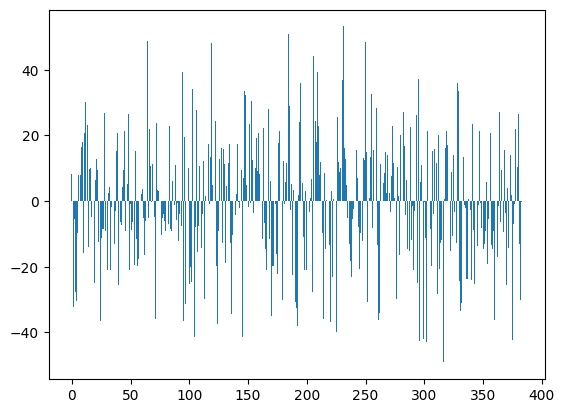

In [104]:
# Plot the scale vector answers.
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()

In [105]:
# Get the adapted query embeddings to compare them with the original values retrieved.
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 15/15 [00:00<00:00, 260.61it/s]


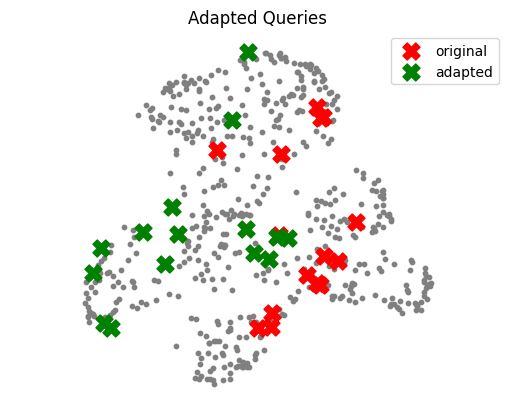

In [106]:
# Plot the adapted embeddings and the original values retrieved.
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()